In [1]:
import time
import copy
import numpy as np
import array as arr
import pandas as pd
import chainer
import chainer.functions as F
import chainer.links as L
import matplotlib.pyplot as plt
from plotly.offline import plot
import datetime
import plotly.graph_objects as go
#from plotly import tools
#from plotly.graph_objs import *
#from plotly.offline import init_notebook_mode, iplot, iplot_mpl


D:\Anaconda\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
D:\Anaconda\lib\site-packages\numpy\.libs\libopenblas.EL2C6PLE4ZYW3ECEVIV3OXXGRN2NRFM2.gfortran-win_amd64.dll
D:\Anaconda\lib\site-packages\numpy\.libs\libopenblas.XWYDX2IKJW2NMTWSFYNGFUWKQU3LYTCZ.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"
D:\Anaconda\lib\site-packages\pkg_resources\__init__.py:123: PkgResourcesDeprecationWarning: 4.0.0-unsupported is an invalid version and will not be supported in a future release
  warnings.warn(


In [2]:
data = pd.read_csv('C:/Users/User/Documents/RL_/Data/Stocks/SPY_Both.txt')
data['Date'] = pd.to_datetime(data['Date'])
data = data.set_index('Date')
print(data.index.min(), data.index.max())
data.head()

2001-01-02 00:00:00 2019-12-30 00:00:00


,Open,High,Low,Close,Adj Close,Volume,Gold_Adj Close,WTI_Adj Close
Date,,,,,,,,
2001-01-02,1320.280029,1320.280029,1276.050049,1283.270020,1283.270020,1129400000,268.399994,27.200001
2001-01-03,1283.270020,1347.760010,1274.619995,1347.560059,1347.560059,1880700000,268.000000,27.950001
2001-01-04,1347.560059,1350.239990,1329.140015,1333.339966,1333.339966,2131000000,267.299988,28.200001
2001-01-05,1333.339966,1334.770020,1294.949951,1298.349976,1298.349976,1430800000,268.000000,28.000000
2001-01-08,1298.349976,1298.349976,1276.290039,1295.859985,1295.859985,1115500000,268.000000,27.350000


In [3]:
DQN_model = '50_2019_Gold_dqn_model.npz'
DDQN_behavior_model = '50_2019_Gold_ddqn_behavior_model.npz'
DDQN_target_model = '50_2019_Gold_ddqn_target_model.npz'
dueling_ddqn_model = '50_2019_Gold_dueling_ddqn_model.npz'

In [4]:
start_date = datetime.datetime(2010, 1, 1)
end_date = datetime.datetime(2019, 12, 31)
total_days = (end_date - start_date).days
train_days = int(total_days * 0.9)
test_start_date = start_date + datetime.timedelta(days=train_days)
date_split = test_start_date.date()
train = data[:date_split]
test = data[date_split:]
print("訓練", start_date.date(), "到", test_start_date.date())
print("測試", test_start_date.date(), "到", end_date.date())

訓練 2010-01-01 到 2018-12-30
測試 2018-12-30 到 2019-12-31


In [5]:
class Environment1:
    
    def __init__(self, data, history_t=90):
        self.data = data
        self.history_t = history_t
        self.reset()
        
    def reset(self):
        self.t = 0
        self.done = False
        self.profits = 10000 #初始資金
        self.count = []
        self.positions = []
        self.position_value = 0
        self.brok_rate=0.0009
        self.max_trade_percent = 0.8
        self.tbrokerage = 0
        self.history = [0 for _ in range(self.history_t)]
        self.Act0=0
        self.Act1=0
        self.Act2=0
        self.RW_p=0
        self.RW_n=0
        self.RW_p_v=0
        self.RW_n_v=0
        self.TP = 0
        self.TN = 0
        self.FP = 0
        self.FN = 0
        return [self.position_value] + self.history # obs
    
    def step(self, act, amount):
        if self.t >= len(self.data) - 1:
            self.done = True
            return [self.position_value] + self.history, 0, self.done
        reward = 0
        current_price = self.data.iloc[self.t]['Close']
        #print(act)
        #print(amount)
        # act = 0: stay, 1: buy, 2: sell
        if act == 1:
            future_price = self.check_future_price(days=19)
            if future_price > current_price:  # 預測正確，價格上漲
                self.TP += 1
            else:  # 預測錯誤，價格未上漲
                self.FP += 1 
            if self.profits != 0:
                max_trade_amount = self.profits*self.max_trade_percent
                stock_price = self.data.iloc[self.t, :]['Close']
                count = max_trade_amount / stock_price
                #self.tbrokerage = self.brok_rate*self.data.iloc[self.t, :]['Close']
                buyin = stock_price * count
                self.profits = self.profits - buyin 
                #print('\t'.join(map(str, ['buy',self.data.iloc[self.t, :]['Close'], amount, buyin, self.profits])))
                self.positions.append(stock_price)
                self.count.append(count)
                self.Act1+=1
                #print('\t'.join(map(str, ['buy', amount, buyin, self.profits])))
                
        elif act == 2: # sell
            future_price = self.check_future_price(days=19)
            if future_price < current_price:  # 預測正確，價格下跌
                self.TN += 1
            else:  # 預測錯誤，價格未下跌
                self.FN += 1
            if len(self.positions) > 0:
                sell_ratio = self.determine_sell_ratio(amount)
                num_positions_to_sell = int(len(self.positions) * sell_ratio)

                for i in range(num_positions_to_sell):
                    sell_price = self.data.iloc[self.t, :]['Close']
                    buy_price = self.positions[i]
                    count = self.count[i]
                    abs_num = (sell_price - buy_price) * count
                    if abs_num > 0: 
                        self.RW_p += 1 
                        self.RW_p_v += abs_num
                    else: 
                        self.RW_n += 1
                        self.RW_n_v += abs(abs_num)
                    reward += sell_price * count
                    self.profits += sell_price * count
                self.positions = self.positions[num_positions_to_sell:]
                self.count = self.count[num_positions_to_sell:]
                self.Act2 += 1    
        
        else :
            self.Act0+=1
        
        # set next time
        self.t += 1
        self.position_value = 0
        for p in self.positions:
            self.position_value += (self.data.iloc[self.t, :]['Close'] - p)
        self.history.pop(0)
        self.history.append(self.data.iloc[self.t, :]['Close'] - self.data.iloc[(self.t-1), :]['Close'])
        
        # clipping reward
        if reward > 0:
            reward = 1
        elif reward < 0:
            reward = -1
        
        return [self.position_value] + self.history, reward, self.done # obs, reward, done
    def determine_sell_ratio(self, signal_strength):
        # Example thresholds and ratios
        thresholds = [0.2, 0.5, 0.8]
        ratios = [0.25, 0.5, 0.75]

        for i, threshold in enumerate(thresholds):
            if signal_strength < threshold:
                return ratios[i]
        return ratios[0]  # Sell the largest ratio but not everything if the signal is very strong
    def check_future_price(self, days=19):
        """檢查未來指定天數內的價格變化"""
        if self.t + days < len(self.data):
            return self.data.iloc[self.t + days]['Close']
        else:
            return self.data.iloc[-1]['Close']

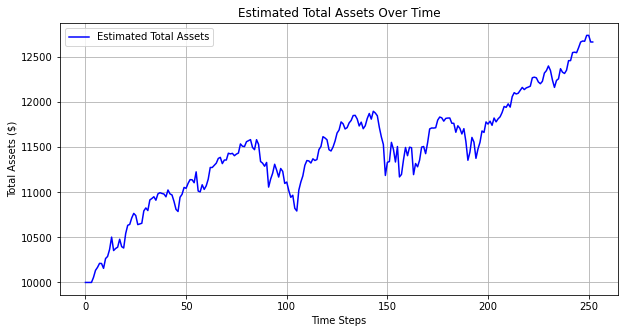

Final profits: 12668.017504596732
TP: 67
FP: 22
TN: 0
FN: 0
Precision: 0.7528
Recall: 1.0000
F1 Score: 0.8590


In [6]:
import matplotlib.pyplot as plt
#DQN
def test_dqn(test_env, Q, confidence_threshold_buy=0.1, confidence_threshold_sell=0.8):
    # 重置环境
    pobs = test_env.reset()
    test_env.profits = 10000  # 重置初始资金
    test_acts = []
    test_rewards = []
    estimated_total_assets = [test_env.profits]  # 记录每步的总资产，初始资金为起始值

    while not test_env.done:
        # 使用DQN产生行动的概率分布
        q_values = Q(np.array(pobs, dtype=np.float32).reshape(1, -1))
        softmax_q_values = F.softmax(q_values).data
        pact = np.random.choice(3, p=softmax_q_values.ravel())
        
        # 根据设定的阈值判断是否执行买入或卖出
        amount = softmax_q_values.ravel()[pact]
        if pact == 2 and amount < confidence_threshold_sell:
            pact = 0
        elif pact == 1 and amount < confidence_threshold_buy:
            pact = 0
        
        # 执行行动
        obs, reward, done = test_env.step(pact, amount)
        test_acts.append(pact)
        test_rewards.append(reward)
        pobs = obs

        # 估算总资产
        stock_value = sum(c * test_env.data.iloc[test_env.t]['Close'] for c in test_env.count)
        total_assets = test_env.profits + stock_value
        estimated_total_assets.append(total_assets)

    # 绘制估算总资产的折线图
    plt.figure(figsize=(10, 5))
    plt.plot(estimated_total_assets, label='Estimated Total Assets', color='blue')
    plt.title('Estimated Total Assets Over Time')
    plt.xlabel('Time Steps')
    plt.ylabel('Total Assets ($)')
    plt.legend()
    plt.grid(True)
    plt.show()

    final_profits = total_assets
    return test_acts, test_rewards, final_profits
def load_and_test_dqn(test_env):

    class Q_Network(chainer.Chain):

        def __init__(self, input_size, hidden_size, output_size):
            super(Q_Network, self).__init__(
                fc1 = L.Linear(input_size, hidden_size),
                fc2 = L.Linear(hidden_size, hidden_size),
                fc3 = L.Linear(hidden_size, output_size)
            )

        def __call__(self, x):
            h = F.relu(self.fc1(x))
            h = F.relu(self.fc2(h))
            y = self.fc3(h)
            return y

        def reset(self):
            self.zerograds()
    Q_loaded = Q_Network(input_size=test_env.history_t+1, hidden_size=100, output_size=3)
    chainer.serializers.load_npz(DQN_model, Q_loaded)
    
    # 现在使用加载的模型来进行测试
    test_acts, test_rewards, test_profits = test_dqn(test_env, Q_loaded)
    #print("Test actions:", test_acts)
    #print("Test rewards:", test_rewards)
    print("Final profits:", test_profits)
def calculate_metrics(env):
    """
    計算 Precision, Recall 和 F1 分數
    """
    print("TP:", env.TP)
    print("FP:", env.FP)
    print("TN:", env.TN)
    print("FN:", env.FN)
    precision = env.TP / (env.TP + env.FP) if (env.TP + env.FP) > 0 else 0
    recall = env.TP / (env.TP + env.FN) if (env.TP + env.FN) > 0 else 0
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    return precision, recall, f1_score
# 调用函数进行测试
test_data = test  # 确保已正确设置测试数据
test_env = Environment1(data=test_data, history_t=90)
load_and_test_dqn(test_env)
precision, recall, f1_score = calculate_metrics(test_env)

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1_score:.4f}")

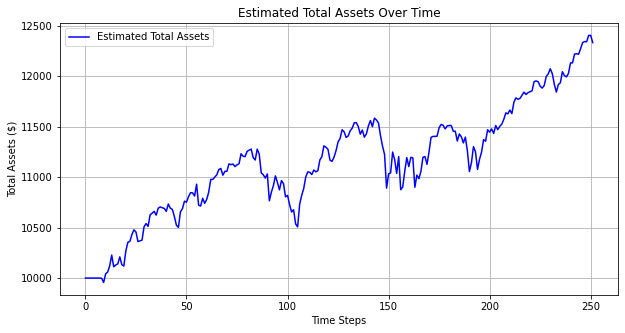

Final profits: 12332.700821047827
TP: 28
FP: 13
TN: 0
FN: 0
Precision: 0.6829
Recall: 1.0000
F1 Score: 0.8116


In [7]:
import matplotlib.pyplot as plt
#DDQN
def test_ddqn(test_env, Q, Q_ast, buy_threshold=0.1, sell_threshold=0.8):
    # 重置环境并获取初始状态
    pobs = test_env.reset()
    test_env.profits = 10000  # 如果需要的话，重置初始资金
    test_acts = []
    test_rewards = []
    test_profits = [test_env.profits]  # 记录每一步后的利润
    estimated_total_assets = [test_env.profits]  # 包括估算的持股价值的总资产列表

    while not test_env.done:
        # 使用训练好的DDQN模型选择行动
        q_values = Q(np.array(pobs, dtype=np.float32).reshape(1, -1))
        softmax_q_values = F.softmax(q_values).data.ravel()
        action = np.random.choice(3, p=softmax_q_values)
        action_prob = softmax_q_values[action]
        amount = action_prob

        # 根据阈值判断是否执行买入或卖出
        if action == 1 and action_prob < buy_threshold:
            action = 0
            amount = 0
        elif action == 2 and action_prob < sell_threshold:
            action = 0
            amount = 0

        obs, reward, done = test_env.step(action, amount)
        if done:
            break
        test_acts.append(action)
        test_rewards.append(reward)
        pobs = obs
        test_profits.append(test_env.profits)

        # 估算总资产（不实际卖出股票）
        stock_value = sum(c * test_env.data.iloc[test_env.t]['Close'] for c in test_env.count)
        total_assets = test_env.profits + stock_value
        estimated_total_assets.append(total_assets)
    # 测试最后一天，将所有持股转换为现金
    final_stock_value = sum(c * test_env.data.iloc[-1]['Close'] for c in test_env.count)
    final_profits = test_env.profits + final_stock_value
    estimated_total_assets[-1] = final_profits  # 更新最后的总资产估计值
    #print("Test actions:", test_acts)
    #print("Test rewards:", test_rewards)
    

    # 绘制总资产变化的折线图
    plt.figure(figsize=(10, 5))
    plt.plot(estimated_total_assets, label='Estimated Total Assets', color='blue')
    plt.title('Estimated Total Assets Over Time')
    plt.xlabel('Time Steps')
    plt.ylabel('Total Assets ($)')
    plt.legend()
    plt.grid(True)
    plt.show()
    print("Final profits:", final_profits)
    return test_acts, test_rewards, final_profits
def calculate_metrics(env):
    """
    計算 Precision, Recall 和 F1 分數
    """
    print("TP:", env.TP)
    print("FP:", env.FP)
    print("TN:", env.TN)
    print("FN:", env.FN)
    precision = env.TP / (env.TP + env.FP) if (env.TP + env.FP) > 0 else 0
    recall = env.TP / (env.TP + env.FN) if (env.TP + env.FN) > 0 else 0
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    return precision, recall, f1_score

class Q_Network(chainer.Chain):

    def __init__(self, input_size, hidden_size, output_size):
        super(Q_Network, self).__init__(
            fc1 = L.Linear(input_size, hidden_size),
            fc2 = L.Linear(hidden_size, hidden_size),
            fc3 = L.Linear(hidden_size, output_size)
        )

    def __call__(self, x):
        h = F.relu(self.fc1(x))
        h = F.relu(self.fc2(h))
        y = self.fc3(h)
        return y

    def reset(self):
        self.zerograds() 

# 确保以下是您实际调用测试函数的部分
test_data = test  # 确保已正确设置测试数据
test_env = Environment1(data=test_data, history_t=90)

Q_loaded = Q_Network(input_size=test_env.history_t+1, hidden_size=100, output_size=3)
chainer.serializers.load_npz(DDQN_behavior_model, Q_loaded)

Q_ast_loaded = Q_Network(input_size=test_env.history_t+1, hidden_size=100, output_size=3)
chainer.serializers.load_npz(DDQN_target_model, Q_ast_loaded)

# 运行测试
test_acts, test_rewards, test_profits = test_ddqn(test_env, Q_loaded, Q_ast_loaded)
precision, recall, f1_score = calculate_metrics(test_env)

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1_score:.4f}")

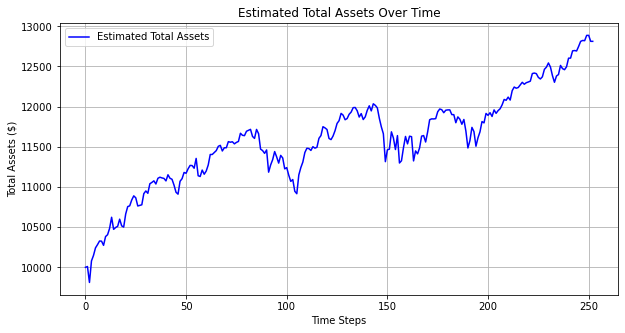

Final profits: 12813.074531601598
TP: 47
FP: 10
TN: 0
FN: 0
Precision: 0.8246
Recall: 1.0000
F1 Score: 0.9038


In [8]:
import plotly.graph_objects as go
import numpy as np

def test_dueling_ddqn(test_env, Q, buy_threshold=0.1, sell_threshold=0.8):
    pobs = test_env.reset()
    test_env.profits = 10000  # 重置初始资金
    test_acts = []
    test_rewards = []
    test_profits = []
    estimated_total_assets = [test_env.profits]  # 包括估算的持股价值的总资产列表
    while not test_env.done:
        q_values = Q(np.array(pobs, dtype=np.float32).reshape(1, -1))
        softmax_q_values = F.softmax(q_values).data.ravel()
        action = np.random.choice(3, p=softmax_q_values)  # 随机选择行动，基于概率分布
        action_prob = softmax_q_values[action]

        # 设置交易的金额或数量，这里假设简单地将概率值转换为金额或比例
        amount = action_prob

        # 考虑不同行动的阈值
        if action == 1 and action_prob < buy_threshold:  # 买入行动的阈值判断
            action = 0  # 如果买入概率低于买入阈值，则不买入
            amount = 0
        elif action == 2 and action_prob < sell_threshold:  # 卖出行动的阈值判断
            action = 0  # 如果卖出概率低于卖出阈值，则不卖出
            amount = 0

        obs, reward, done = test_env.step(action, amount)
        test_acts.append(action)
        test_rewards.append(reward)
        pobs = obs

        # 估计每日的现有资金（假设所有持仓都卖出但不真正执行）
        simulated_profits = test_env.profits + sum(pos * test_env.data.iloc[test_env.t, :]['Close'] for pos in test_env.count)
        test_profits.append(simulated_profits)
        estimated_total_assets.append(simulated_profits)
    # 绘制折线图显示每日利润变化
    plt.figure(figsize=(10, 5))
    plt.plot(estimated_total_assets, label='Estimated Total Assets', color='blue')
    plt.title('Estimated Total Assets Over Time')
    plt.xlabel('Time Steps')
    plt.ylabel('Total Assets ($)')
    plt.legend()
    plt.grid(True)
    plt.show()
    test_env.profits = simulated_profits
    return test_acts, test_rewards, test_env.profits

def calculate_metrics(env):
    """
    計算 Precision, Recall 和 F1 分數
    """
    print("TP:", env.TP)
    print("FP:", env.FP)
    print("TN:", env.TN)
    print("FN:", env.FN)
    precision = env.TP / (env.TP + env.FP) if (env.TP + env.FP) > 0 else 0
    recall = env.TP / (env.TP + env.FN) if (env.TP + env.FN) > 0 else 0
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    return precision, recall, f1_score

def load_and_test_dueling_ddqn(test_env):
    class Q_Network(chainer.Chain):

        def __init__(self, input_size, hidden_size, output_size):
            super(Q_Network, self).__init__(
                fc1 = L.Linear(input_size, hidden_size),
                fc2 = L.Linear(hidden_size, hidden_size),
                fc3 = L.Linear(hidden_size, hidden_size//2),
                fc4 = L.Linear(hidden_size, hidden_size//2),
                state_value = L.Linear(hidden_size//2, 1),
                advantage_value = L.Linear(hidden_size//2, output_size)
            )
            self.input_size = input_size
            self.hidden_size = hidden_size
            self.output_size = output_size

        def __call__(self, x):
            h = F.relu(self.fc1(x))
            h = F.relu(self.fc2(h))
            hs = F.relu(self.fc3(h))
            ha = F.relu(self.fc4(h))
            state_value = self.state_value(hs)
            advantage_value = self.advantage_value(ha)
            advantage_mean = (F.sum(advantage_value, axis=1)/float(self.output_size)).reshape(-1, 1)
            q_value = F.concat([state_value for _ in range(self.output_size)], axis=1) + (advantage_value - F.concat([advantage_mean for _ in range(self.output_size)], axis=1))
            return q_value

        def reset(self):
            self.zerograds()
    Q_loaded = Q_Network(input_size=test_env.history_t+1, hidden_size=100, output_size=3)
    chainer.serializers.load_npz(dueling_ddqn_model, Q_loaded)
    test_acts, test_rewards, test_profits = test_dueling_ddqn(test_env, Q_loaded, buy_threshold=0.1, sell_threshold=0.6)
    #print("Test actions:", test_acts)
    #print("Test rewards:", test_rewards)
    print("Final profits:", test_profits)

test_data = test  # 这里应该是您加载或定义测试数据集的代码
test_env = Environment1(data=test_data, history_t=90)
load_and_test_dueling_ddqn(test_env)
precision, recall, f1_score = calculate_metrics(test_env)

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1_score:.4f}")